
Start Time : 2023-09-06 11:10:36.045342
Mean RFI Amp. : 119 Jy
Flag Rate :     92.07 %

Number of Antennas: 4

Number of Time Steps: 450

Max and Min Vis samples : (36, 5)

Energy per data point @ true: 2.0705431429615824

U compiled 1 time(s).

Number of data points: 5400

Number of parameters: 1259

Energy per data point @ qi: 30.364507729187046



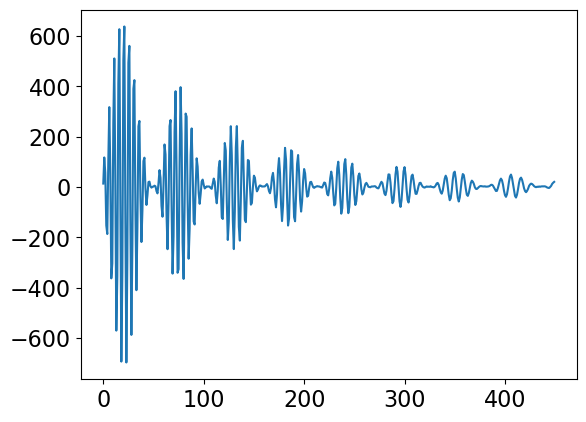

In [70]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from datetime import datetime

print()
start = datetime.now()
print(f"Start Time : {start}")


# In[2]:


from tab_opt.mcmc import (
    inv_kernel_vmap,
    inv_kernel,
    log_normal,
    log_multinorm,
    log_multinorm_sum,
)
from tab_opt.transform import (
    affine_transform_full,
    affine_transform_full_inv,
    affine_transform_diag,
    affine_transform_diag_inv,
)
from tab_opt.data import extract_data
from tabascal.jax.coordinates import orbit
from tabascal.utils.jax import progress_bar_scan

from jax import random, jit, vmap, jacrev
import jax.numpy as jnp

from jax.flatten_util import ravel_pytree as flatten
from jax.lax import scan

from jax.tree_util import tree_map
import jax

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py

import xarray as xr

plt.rcParams["font.size"] = 16


# In[3]:


# f_name = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/target_obs_08A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD/"

f_name = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/examples/data/target_obs_04A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD/"

# f_name = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/examples/data/target_obs_08A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD/"

# f_name = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/examples/data/target_obs_16A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD/"


# In[4]:

N_time = 450
sampling = 1

(
    N_int_samples,
    N_ant,
    N_bl,
    a1,
    a2,
    times,
    times_fine,
    bl_uvw,
    ants_uvw,
    ants_xyz,
    vis_ast,
    vis_rfi,
    vis_obs,
    noise,
    noise_data,
    int_time,
    freqs,
    gains_ants,
    rfi_A_app,
    rfi_orbit,
) = extract_data(f_name, sampling=sampling, N_time=N_time)

# In[5]:


from tabascal.jax.interferometry import ants_to_bl

gains_bl = ants_to_bl(gains_ants.reshape(N_time, -1, N_ant, 1).mean(axis=1), a1, a2)

v_ast = vis_ast.reshape(N_time, -1, N_bl, 1).mean(axis=1)

v_cal = vis_obs / gains_bl

flags = jnp.where(jnp.abs(v_ast - v_cal) > 3 * noise, True, False)


# In[6]:


rng = np.random.default_rng(123)
rfi_gains = (
    np.exp(1.0j * times_fine / 100.0)[:, None, None]
    * np.exp(2.0j * np.pi * rng.uniform(size=N_ant))[None, :, None]
)

v_rfi = rfi_gains[:, a1] * np.conj(rfi_gains[:, a2]) * vis_rfi


# In[7]:


v_obs = (gains_ants[:, a1] * np.conj(gains_ants[:, a2]) * (vis_ast + v_rfi)).reshape(
    N_time, N_int_samples, N_bl, 1
).mean(axis=1) + noise_data


# In[8]:


print(
    f"Mean RFI Amp. : {jnp.mean(jnp.abs(v_rfi)):.0f} Jy\nFlag Rate :     {100*flags.mean():.2f} %"
)


# In[9]:


print()
print(f"Number of Antennas: {N_ant}")
print()
print(f"Number of Time Steps: {N_time}")


# In[10]:


@jit
def kernel(x, x_, var, l, noise=1e-3):
    """
    x: array (n_points, n_dim)
    """
    x = x[:, None] if x.ndim == 1 else x
    x_ = x_[:, None] if x_.ndim == 1 else x_
    chi = jnp.linalg.norm(x[None, :, :] - x_[:, None, :], axis=-1) / l
    cov = jnp.abs(var) * jnp.exp(-0.5 * chi**2)
    if chi.shape[0] == chi.shape[1]:
        cov += noise * jnp.eye(x.shape[0])
    return cov


@jit
def resampling_kernel(x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s @ K_inv


# In[11]:


@jit
def gp_resample(y, x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s @ K_inv @ y


@jit
def resampled_cov(x, x_, var, l, noise_cov):
    K = kernel(x, x, var, l, 1e-3)
    K_inv = jnp.linalg.inv(K + noise_cov)
    K_s = kernel(x, x_, var, l)
    K_ss = kernel(x_, x_, var, l)
    return K_ss - K_s @ K_inv @ K_s.T


# In[12]:


def l_from_uv(uv, l0=7e2, a=6e-4):
    return l0 * jnp.exp(-a * uv)


def get_times(gp_l, times):
    int_time = times[1] - times[0]
    t_i = times[0] - int_time / 2
    t_f = times[-1] + int_time / 2
    n_vis_times = jnp.ceil(2.0 * ((t_f - t_i) / gp_l) + 1).astype(int)
    vis_times = jnp.linspace(t_i, t_f, n_vis_times)

    return vis_times


def fringe_phasor(w, freq):
    from tabascal.jax.interferometry import c

    phasor = jnp.exp(-2.0j * jnp.pi * freq / c * w)

    return phasor


def derotated_vis_phase(vis, w, freq):
    derotated_vis = vis * fringe_phasor(w, freq)
    phase = jnp.unwrap(jnp.angle(derotated_vis), discont=0.0)

    return phase


def derotated_vis(vis, w, freq):
    return vis * fringe_phasor(w, freq)


# In[13]:


@jit
def rfi_closures(q, params, ants):
    # rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant,N_rfi_time)[ants]
    # rfi_amp = (params['resample_rfi']@rfi_amp.T).T

    rfi_real = flatten(q["rfi_real"])[0].reshape(N_ant, N_rfi_time)[ants]
    rfi_imag = flatten(q["rfi_imag"])[0].reshape(N_ant, N_rfi_time)[ants]
    rfi_amp = (params["resample_rfi"] @ (rfi_real + 1.0j * rfi_imag).T).T

    rfi_xyz = orbit(params["times_fine"], *q["rfi_orbit"])
    distances = jnp.linalg.norm(
        params["ants_xyz"][:, ants] - rfi_xyz[:, None, :], axis=2
    )
    c_distances = (distances - params["phase_corrections"][:, ants])[..., None]

    return rfi_amp, c_distances


@jit
def rfi_vis(app_amplitude, c_distances, freqs):
    """
    Calculate visibilities from distances to rfi sources.

    Parameters:
    -----------
    app_amplitude: jnp.array (n_time, 2, n_freq, n_src)
        Apparent amplitude at the antennas.
    c_distances: jnp.array (n_time, 2, n_src)
        The phase corrected distances between the rfi sources and the antennas.
    freqs: jnp.array (n_freq,)
        Frequencies.

    Returns:
    --------
    vis: jnp.array (n_time, 1, n_freq)
        The visibilities.
    """
    n_time, n_ant, n_freq, n_src = app_amplitude.shape
    c = 2.99792458e8

    # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

    minus_two_pi_over_lamda = (-2.0 * jnp.pi * freqs / c).reshape(1, 1, n_freq, 1)

    c_distances = c_distances.reshape(n_time, n_ant, 1, n_src)

    phase = minus_two_pi_over_lamda * (c_distances[:, 0] - c_distances[:, 1])
    intensities_app = app_amplitude[:, 0] * jnp.conj(app_amplitude[:, 1])

    vis = jnp.sum(intensities_app * jnp.exp(1.0j * phase), axis=-1)

    return vis


@jit
def baseline_gains(q, params, ants):
    G_amp = flatten(q["g_amp"])[0].reshape(N_ant, N_g_time)[ants]
    G_phase = flatten(q["g_phase"])[0].reshape(N_ant - 1, N_g_time)
    G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)[ants]

    G_amp = (params["resample_g_amp"] @ G_amp.T).T
    G_phase = (params["resample_g_phase"] @ G_phase.T).T

    G = G_amp * jnp.exp(1.0j * G_phase)

    return G[0] * jnp.conjugate(G[1])


@jit
def pad_vis(vis):
    return jnp.pad(vis, (0, N_vis_time - vis.shape[0]))


@jit
def rfi_vis_model(q, params, ant1, ant2):
    # q = scale_parameters(q, inv_scalings)

    ants = jnp.array([ant1, ant2])

    rfi_amp, c_distances = rfi_closures(q, params, ants)
    V_rfi = rfi_vis(rfi_amp.T[:, :, None, None], c_distances, params["freqs"])[..., 0]

    return V_rfi


@jit
def ast_vis_model(q, params, bl):
    V_real = flatten(tree_map(pad_vis, q["v_real"]))[0].reshape(N_bl, N_vis_time)[bl]
    V_imag = flatten(tree_map(pad_vis, q["v_imag"]))[0].reshape(N_bl, N_vis_time)[bl]
    V_ast = V_real + 1.0j * V_imag

    V_ast = params["resample_vis"][bl] @ V_ast

    return V_ast


@jit
def model(q, params, ant1, ant2, bl):
    
    # q = transform_parameters(q, params)

    ants = jnp.array([ant1, ant2])

    V_real = flatten(tree_map(pad_vis, q["v_real"]))[0].reshape(N_bl, N_vis_time)[bl]
    V_imag = flatten(tree_map(pad_vis, q["v_imag"]))[0].reshape(N_bl, N_vis_time)[bl]
    V_ast = V_real + 1.0j * V_imag

    V_ast = params["resample_vis"][bl] @ V_ast

    #     Calculate the visibility contribution from the RFI
    rfi_amp, c_distances = rfi_closures(q, params, ants)
    V_rfi = rfi_vis(rfi_amp.T[:, :, None, None], c_distances, params["freqs"])[..., 0]
    V_rfi = V_rfi.reshape(N_time, N_int_samples).mean(axis=1)

    G_bl = baseline_gains(q, params, ants)

    model_vis = G_bl * (V_ast + V_rfi)

    return jnp.concatenate([model_vis.real.flatten(), model_vis.imag.flatten()])


@jit
def transform_parameters(q, transform_params):
    q_new = {
        "rfi_orbit": affine_transform_full(
            q["rfi_orbit"],
            transform_params["L_RFI_orbit"],
            transform_params["mu_RFI_orbit"],
        ),
        "rfi_real": tree_map(
            lambda x: affine_transform_diag(
                x, transform_params["std_RFI"], transform_params["mu_RFI"]
            ),
            q["rfi_real"],
        ),
        "rfi_imag": tree_map(
            lambda x: affine_transform_diag(
                x, transform_params["std_RFI"], transform_params["mu_RFI"]
            ),
            q["rfi_imag"],
        ),
        "g_amp": tree_map(
            lambda x, mu: affine_transform_full(x, transform_params["L_G_amp"], mu),
            q["g_amp"],
            transform_params["mu_G_amp"],
        ),
        "g_phase": tree_map(
            lambda x, mu: affine_transform_full(x, transform_params["L_G_phase"], mu),
            q["g_phase"],
            transform_params["mu_G_phase"],
        ),
        "v_real": tree_map(
            affine_transform_full,
            q["v_real"],
            transform_params["L_vis"],
            transform_params["mu_vis"],
        ),
        "v_imag": tree_map(
            affine_transform_full,
            q["v_imag"],
            transform_params["L_vis"],
            transform_params["mu_vis"],
        ),
    }
    return q_new


@jit
def inv_transform_parameters(q, transform_params):
    q_new = {
        "rfi_orbit": affine_transform_full_inv(
            q["rfi_orbit"],
            jnp.linalg.inv(transform_params["L_RFI_orbit"]),
            transform_params["mu_RFI_orbit"],
        ),
        "rfi_real": tree_map(
            lambda x: affine_transform_diag_inv(
                x, 1.0 / transform_params["std_RFI"], transform_params["mu_RFI"]
            ),
            q["rfi_real"],
        ),
        "rfi_imag": tree_map(
            lambda x: affine_transform_diag_inv(
                x, 1.0 / transform_params["std_RFI"], transform_params["mu_RFI"]
            ),
            q["rfi_imag"],
        ),
        "g_amp": tree_map(
            lambda x, mu: affine_transform_full_inv(
                x, jnp.linalg.inv(transform_params["L_G_amp"]), mu
            ),
            q["g_amp"],
            transform_params["mu_G_amp"],
        ),
        "g_phase": tree_map(
            lambda x, mu: affine_transform_full_inv(
                x, jnp.linalg.inv(transform_params["L_G_phase"]), mu
            ),
            q["g_phase"],
            transform_params["mu_G_phase"],
        ),
        "v_real": tree_map(
            affine_transform_full_inv,
            q["v_real"],
            transform_params["L_vis_inv"],
            transform_params["mu_vis"],
        ),
        "v_imag": tree_map(
            affine_transform_full_inv,
            q["v_imag"],
            transform_params["L_vis_inv"],
            transform_params["mu_vis"],
        ),
    }
    return q_new

# Calculate approximate True values


def l_from_uv(uv, l0=7e2, a=6e-4):
    return l0 * jnp.exp(-a * uv)


a1, a2 = jnp.triu_indices(N_ant, 1)
mag_uvw = jnp.linalg.norm(ants_uvw[0, a1] - ants_uvw[0, a2], axis=-1)
vis_var = (jnp.abs(vis_ast).max(axis=(0, 2)) + noise) ** 2
vis_l = l_from_uv(mag_uvw, l0=5e2)

g_amp_var = (0.01) ** 2
g_phase_var = (jnp.deg2rad(1.0)) ** 2
g_l = 10e3

rfi_var, rfi_l = 1e6, 15.0

T_time = times[-1] - times[0] + int_time
n_vis_times = jnp.ceil(2.0 * T_time / vis_l).astype(int)
get_times = partial(jnp.linspace, *(times[0] - int_time / 2, times[-1] + int_time / 2))
vis_times = tuple(map(get_times, n_vis_times))
N_vis_time = int(n_vis_times.max())

vis_idxs = [
    jnp.floor(jnp.linspace(0, len(times_fine) - 1, n_vis_times[i])).astype(int)
    for i in range(N_bl)
]

Nt_fine = len(times_fine)
#####
Nt_g = N_int_samples * 45
# Nt_g = N_int_samples * 150
g_idx = jnp.array(
    list(np.arange(0, Nt_fine, Nt_g))
    + [
        Nt_fine - 1,
    ]
)
times_g = times_fine[g_idx]
N_g_time = len(times_g)
G = gains_ants[g_idx, :, 0].T
#####

def get_times(gp_l, times):
    int_time = times[1] - times[0]
    t_i = times[0] - int_time / 2
    t_f = times[-1] + int_time / 2
    n_vis_times = jnp.ceil(2.0 * ((t_f - t_i) / gp_l) + 1).astype(int)
    vis_times = jnp.linspace(t_i, t_f, n_vis_times)

    return vis_times

times_rfi = get_times(rfi_l, times)
rfi_induce = vmap(jnp.interp, in_axes=(None, None, 1))(
    times_rfi, times_fine, (rfi_A_app * rfi_gains)[:, :, 0]
)

rfi_real = rfi_induce.real
rfi_imag = rfi_induce.imag

N_rfi_time = len(times_rfi)


# Nt_rfi = N_int_samples  # 2
# rfi_idx = jnp.array(
#     list(np.arange(0, Nt_fine, Nt_rfi))
#     + [
#         Nt_fine - 1,
#     ]
# )
# times_rfi = times_fine[rfi_idx]
# N_rfi_time = len(times_rfi)
# rfi_A = rfi_A_app[rfi_idx, :, 0].T

# rfi_signal = rfi_A_app * rfi_gains
# rfi_real = rfi_signal[rfi_idx, :, 0].T.real
# rfi_imag = rfi_signal[rfi_idx, :, 0].T.imag

######
true_values = {
    "g_amp": {i: x for i, x in enumerate(jnp.abs(G))},
    "g_phase": {i: x for i, x in enumerate(jnp.angle(G[:-1]))},
    "rfi_real": {i: x for i, x in enumerate(rfi_real)},
    "rfi_imag": {i: x for i, x in enumerate(rfi_imag)},
    "rfi_orbit": rfi_orbit,
    "v_real": {i: vis_ast.real[vis_idxs[i], i, 0] for i in range(N_bl)},
    "v_imag": {i: vis_ast.imag[vis_idxs[i], i, 0] for i in range(N_bl)},
}

####################################################################


# In[15]:


# Set Constant Parameters
params = {
    "freqs": freqs,
    "times_fine": times_fine,
    "noise": noise if noise > 0 else 0.2,
    "ants_xyz": ants_xyz,
    "phase_corrections": ants_uvw[..., -1],
    # 'vis_obs': vis_obs[:,:,0],
    "vis_obs": v_obs[:, :, 0],
}


def sym(x):
    return (x + x.T) / 2.0


rfi_cov_fp = "../notebooks/data/RFIorbitCov5min.npy"

transform_params = {
    "mu_RFI_orbit": rfi_orbit,
    "L_RFI_orbit": jnp.linalg.cholesky(np.load(rfi_cov_fp)),
    "mu_RFI": 0.0,
    "std_RFI": 100.0,
    "mu_G_amp": {i: x for i, x in enumerate(jnp.abs(G))},
    "L_G_amp": jnp.linalg.cholesky(
        kernel(times_g[:, None], times_g[:, None], g_amp_var, g_l, 1e-8)
    ),
    "mu_G_phase": {i: x for i, x in enumerate(jnp.angle(G)[:-1])},
    "L_G_phase": jnp.linalg.cholesky(
        kernel(times_g[:, None], times_g[:, None], g_phase_var, g_l, 1e-8)
    ),
    "mu_vis": {i: jnp.zeros(len(vis_times[i])) for i in range(N_bl)},
    "L_vis": {
        i: jnp.linalg.cholesky(
            kernel(
                vis_times[i][:, None], vis_times[i][:, None], vis_var[i], vis_l[i], 1e-3
            )
        )
        for i in range(N_bl)
    },
    "L_vis_inv": {
        i: jnp.linalg.inv(
            jnp.linalg.cholesky(
                kernel(
                    vis_times[i][:, None],
                    vis_times[i][:, None],
                    vis_var[i],
                    vis_l[i],
                    1e-3,
                )
            )
        )
        for i in range(N_bl)
    },
}


true_values = inv_transform_parameters(true_values, transform_params)
# true_values = scale_parameters(true_values, scalings)
flat_true_values, unflatten = flatten(true_values)

sample_params = {
    "resample_vis": {
        i: resampling_kernel(vis_times[i], times, vis_var[i], vis_l[i], 1e-3)
        for i in range(N_bl)
    },
    "resample_g_amp": resampling_kernel(times_g, times, g_amp_var, g_l, 1e-8),
    "resample_g_phase": resampling_kernel(times_g, times, g_phase_var, g_l, 1e-8),
    "resample_rfi": resampling_kernel(
        times_rfi, params["times_fine"], rfi_var, rfi_l, 1e-6
    ),
}

sample_params["resample_vis"] = jnp.array(
    [
        jnp.pad(x, ((0, 0), (0, N_vis_time - x.shape[1])))
        for x in sample_params["resample_vis"].values()
    ]
)

params.update(transform_params)
params.update(sample_params)

flatten(true_values["v_real"])[0].shape[0], N_vis_time * N_bl, N_time * N_bl, flatten(
    true_values["v_real"]
)[0].shape[0] / (N_vis_time * N_bl), flatten(true_values["v_real"])[0].shape[0] / (
    N_time * N_bl
)


# In[16]:


print()
print(f"Max and Min Vis samples : ({int(n_vis_times.max())}, {int(n_vis_times.min())})")


@jit
def nlp(q, params):
    flat_q = flatten(q)[0]
    return -1.0 * jnp.sum(log_normal(flat_q, 0.0, 1.0))


@jit
def nll(q, params, ant1, ant2, bl):
    V_model = model(q, params, ant1, ant2, bl)

    V_obs = jnp.concatenate(
        [params["vis_obs"][:, bl].real, params["vis_obs"][:, bl].imag]
    )

    return -1.0 * log_normal(V_obs, V_model, params["noise"] / jnp.sqrt(2))


@jit
def U(q, params, a1, a2, bl):
    
    nl_prior = nlp(q, params)
    
    q = transform_parameters(q, params)
    
    nl_like = vmap(nll, in_axes=(None, None, 0, 0, 0))(q, params, a1, a2, bl).sum()

    nl_post = nl_prior + nl_like

    return nl_post


delU = jit(jacrev(U, 0))


# In[21]:


# get_ipython().run_line_magic("timeit", "-r 3 nlp.lower(true_values, params).compile()")


# In[22]:


@jit
def nl_like(q, params, a1, a2, bl):
    return vmap(nll, in_axes=(None, None, 0, 0, 0))(q, params, a1, a2, bl).sum()


# In[23]:


a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
# get_ipython().run_line_magic(
#     "timeit", "-r 3 nl_like.lower(true_values, params, a1, a2, bl).compile()"
# )


# In[24]:


ant1, ant2, baseline = a1[0], a2[0], bl[0]
vis = model(true_values, params, ant1, ant2, baseline)


# In[25]:


n_log = vmap(nll, in_axes=(None, None, 0, 0, 0))(true_values, params, a1, a2, bl)
n_log = n_log.T[N_time:] + n_log.T[:N_time]
n_log.mean()


# In[26]:


vis_m = vmap(model, in_axes=(None, None, 0, 0, 0))(true_values, params, a1, a2, bl).T


# In[27]:


plt.plot(v_obs[:, 0, 0].real - vis_m[:N_time, 0])
# plt.plot()


# In[28]:


# get_ipython().run_line_magic(
#     "timeit", "-r 3 U.lower(true_values, params, a1, a2, bl).compile()"
# )


# In[29]:


a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
print()
print(
    f"Energy per data point @ true: {U(true_values, params, a1, a2, bl)/vis_obs.size}"
)
print()
print(f"U compiled {U._cache_size()} time(s).")


# In[30]:


# %timeit -r 7 U(true_values, params, a1, a2, bl).block_until_ready()


# In[31]:


# jax.make_jaxpr(U)(true_values, params, a1, a2, bl)


# In[32]:


# %timeit -r 1 jit(jacrev(model)).lower(true_values, params, a1[0], a2[0], bl[0]).compile()


# In[39]:


###############################################################

# F_prior = {
#     "g_amp": {i: params["inv_cov_G_amp"] for i in range(N_ant)},
#     "g_phase": {i: params["inv_cov_G_phase"] for i in range(N_ant - 1)},
#     "rfi_real": {
#         i: jnp.eye(N_rfi_time) / params["rfi_amp_std"] ** 2 for i in range(N_ant)
#     },
#     "rfi_imag": {
#         i: jnp.eye(N_rfi_time) / params["rfi_amp_std"] ** 2 for i in range(N_ant)
#     },
#     "rfi_orbit": params["inv_cov_RFI_orbit"],
#     "v_real": params["inv_cov_vis"],
#     "v_imag": params["inv_cov_vis"],
# }

# zeros_like = lambda x: jnp.zeros((x.size,x.size))
# F_prior = tree_map(zeros_like, true_values)
eye_like = lambda x: jnp.eye(x.size)
F_prior = tree_map(eye_like, true_values)

####################################


def fisher_diag_baseline(q, params, a1, a2, bl):
    Jac_model = jacrev(model)(q, params, a1, a2, bl)
    F_block = tree_map(lambda J: (J**2).sum(axis=0) / params["noise"] ** 2, Jac_model)

    return F_block


def fisher_diag(q, params, ant1, ant2, baseline, F_prior):
    @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_diag_baseline(q, params, ant1[i], ant2[i], baseline[i])
        return tree_map(lambda x, y: x + y, F, F_i), i

    return scan(add_baseline_fisher, F_prior, jnp.arange(N_bl))[0]


# def fisher_diag(q, params, ant1, ant2, baseline, F_prior):
#     Jacmodel = jit(jacrev(model))

#     def fisher_diag_baseline(q, params, a1, a2, bl):
#         J, _ = flatten(Jacmodel(q, params, a1, a2, bl))
#         F_diag = ((J / params["noise"]) ** 2).sum(axis=0)

#         return F_diag

#     #     @progress_bar_scan(N_bl)
#     def add_baseline_fisher(F, i):
#         F_i = fisher_diag_baseline(q, params, ant1[i], ant2[i], baseline[i])
#         return F + F_i

#     F, unflatten = flatten(F_prior)
#     for i in tqdm(range(N_bl)):
#         F = add_baseline_fisher(F, i)

#     return unflatten(F)


def fisher_block(q, params, ant1, ant2, baseline, F_prior):
    Jac_model = jacrev(model)

    def fisher_block_baseline(q, params, a1, a2, bl):
        J = Jac_model(q, params, a1, a2, bl)
        F_block = tree_map(lambda J: J.T @ J / params["noise"] ** 2, J)

        return F_block

    @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_block_baseline(q, params, ant1[i], ant2[i], baseline[i])
        return tree_map(lambda x, y: x + y, F, F_i), i

    return scan(add_baseline_fisher, F_prior, jnp.arange(N_bl))[0]


################
def block_std(F_block):
    std = tree_map(lambda F: jnp.sqrt(jnp.diag(jnp.linalg.inv(F))), F_block)

    return std


#############################################################
q_dev = {
    "v_real": {
        i: x for i, x in enumerate(0.1 * random.normal(random.PRNGKey(10), (N_bl,)))
    },
    "v_imag": {
        i: x for i, x in enumerate(0.1 * random.normal(random.PRNGKey(11), (N_bl,)))
    },
    "g_amp": {
        i: x for i, x in enumerate(1e-2 * random.normal(random.PRNGKey(12), (N_ant,)))
    },
    "g_phase": {
        i: x
        for i, x in enumerate(
            jnp.deg2rad(1.0) * random.normal(random.PRNGKey(13), (N_ant - 1,))
        )
    },
    "rfi_real": {
        i: x for i, x in enumerate(1e-3 * random.normal(random.PRNGKey(14), (N_ant,)))
    },
    "rfi_imag": {
        i: x for i, x in enumerate(1e-3 * random.normal(random.PRNGKey(14), (N_ant,)))
    },
    "rfi_orbit": 1.0 * random.normal(random.PRNGKey(15), (4,)),
}

# q_dev = {
#     "v_real": {
#         i: x for i, x in enumerate(0.65 * random.normal(random.PRNGKey(10), (N_bl,)))
#     },
#     "v_imag": {
#         i: x for i, x in enumerate(0.65 * random.normal(random.PRNGKey(11), (N_bl,)))
#     },
#     "g_amp": {
#         i: x for i, x in enumerate(1.0 * random.normal(random.PRNGKey(12), (N_ant,)))
#     },
#     "g_phase": {
#         i: x
#         for i, x in enumerate(1.0 * random.normal(random.PRNGKey(13), (N_ant - 1,)))
#     },
#     "rfi_real": {
#         i: x for i, x in enumerate(0.1 * random.normal(random.PRNGKey(14), (N_ant,)))
#     },
#     "rfi_imag": {
#         i: x for i, x in enumerate(0.1 * random.normal(random.PRNGKey(14), (N_ant,)))
#     },
#     "rfi_orbit": random.multivariate_normal(
#         random.PRNGKey(15), jnp.zeros(len(cov_RFI_orbit)), 1e0 * cov_RFI_orbit
#     ),
# }

# q_dev = {
#     "v_real": {
#         i: 1 * 0.65 * random.normal(random.PRNGKey(10 + i), (n_vis_times[i],))
#         for i in range(N_bl)
#     },
#     "v_imag": {
#         i: 1 * 0.65 * random.normal(random.PRNGKey(100 + i), (n_vis_times[i],))
#         for i in range(N_bl)
#     },
#     "g_amp": {
#         i: x for i, x in enumerate(1.0 * random.normal(random.PRNGKey(12), (N_ant,)))
#     },
#     "g_phase": {
#         i: x
#         for i, x in enumerate(1.0 * random.normal(random.PRNGKey(13), (N_ant - 1,)))
#     },
#     "rfi_real": {
#         i: x
#         for i, x in enumerate(5 * 0.1 * random.normal(random.PRNGKey(14), (N_ant,)))
#     },
#     "rfi_imag": {
#         i: x
#         for i, x in enumerate(5 * 0.1 * random.normal(random.PRNGKey(14), (N_ant,)))
#     },
#     "rfi_orbit": random.multivariate_normal(
#         random.PRNGKey(15), jnp.zeros(len(cov_RFI_orbit)), 1e0 * cov_RFI_orbit
#     ),
# }

qi = tree_map(lambda x, y: x + y, true_values, q_dev)

# qi = {
#     'v_real':

#########################################

print()
print(f'Number of data points: {2*params["vis_obs"].size}')
print()
print(f"Number of parameters: {len(flatten(qi)[0])}")
print()
print(f'Energy per data point @ qi: {U(qi, params, a1, a2, bl)/params["vis_obs"].size}')
print()
# print(f'U compiled {U._cache_size()} time(s).')
# print()

In [71]:
# In[34]:


# %timeit -r 7 U(qi, params, a1, a2, bl).block_until_ready()


# In[40]:


# F = fisher_block(qi, params, a1, a2, bl, F_prior)
# F_inv = tree_map(jnp.linalg.inv, F)


# In[90]:


# F = fisher_block(qi, params, a1, a2, bl, F_prior)
# F_inv = tree_map(lambda x: 1./np.diag(x), F)


# In[84]:


F_prior_diag = tree_map(jnp.diag, F_prior)
F = fisher_diag(qi, params, a1, a2, bl, F_prior_diag)
F_inv = tree_map(lambda x: 1./x, F)


# In[41]:


####################################################


# @jit
def nat_grad_step(q, a1s, a2s, bls, alpha):
    update = lambda F_inv, D: alpha * F_inv @ D
    # update = lambda F_inv, D: alpha*F_inv*D
    D = delU(q, params, a1s, a2s, bls)
    return tree_map(update, F_inv, D)


def nat_grad(qi, alpha, Niter=1000, tol=1e-6):
    a1, a2 = jnp.triu_indices(N_ant, 1)
    bl = jnp.arange(len(a1))
    U_i = U(qi, params, a1, a2, bl) / vis_obs.size
    pbar = tqdm(range(0, Niter))
    for i in pbar:
        step = alpha * 0.99 ** (i / 10)
        qf = tree_map(lambda x, y: x - y, qi, nat_grad_step(qi, a1, a2, bl, step))
        U_f = U(qf, params, a1, a2, bl) / vis_obs.size
        pbar.set_description(
            f"NL Posterior = {round(float(U_f), 3)}, alpha = {step:.1E}"
        )
        if np.isnan(U_f) or U_f > U_i:
            alpha /= 2
        elif U_i - U_f < tol:
            if U_f > U_i and U_f > 2.0:
                print("Failed to converge!")
                return None
            return qi
        else:
            U_i = U_f
            qi = qf
    return qi

Running for 6 iterations: 100%|███████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


In [73]:
MAP = nat_grad(qi, 1e-4, 10000, 1e-4)
# MAP = nat_grad(MAP, 2e-2, 10000, 1e-5)
# MAP = nat_grad(true_values, 5e-3, 10000, 1e-5)
# MAP = true_values

# print()
# print(f'U compiled {U._cache_size()} time(s).')
# print()
# print(f'nat_grad_step compiled {nat_grad_step._cache_size()} time(s).')

NL Posterior = 22.293, alpha = 1.8E-10:   1%|▎                                               | 78/10000 [00:04<10:29, 15.77it/s]


KeyboardInterrupt: 


Start Time : 2023-09-05 19:13:41.078262
Mean RFI Amp. : 119 Jy
Flag Rate :     92.21 %

Number of Antennas: 8

Number of Time Steps: 450

Max and Min Vis samples : (36, 4)

Energy per data point @ true: 2.0469169718765095

U compiled 1 time(s).

Number of data points: 25200

Number of parameters: 8053

Energy per data point @ qi: 21.89672229295997



NL Posterior = 5.409, alpha = 6.3E-04:   5%|██                                            | 453/10000 [05:20<1:52:29,  1.41it/s]


KeyboardInterrupt: 

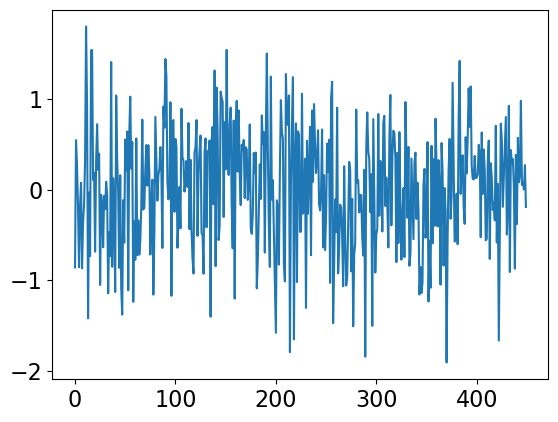

In [1]:
# In[43]:


def saveParams(file_path, q, F_inv):
    with h5py.File(file_path, "w") as fp:
        fp["times_fine"] = times

        for i in range(len(q["v_real"])):
            fp[f"vis/{i}"] = q["v_real"][i] + 1.0j * q["v_imag"][i]
            fp[f"vis_cov/{i}"] = F_inv["v_real"][i]
            fp[f"vis_times/{i}"] = vis_times[i]
        fp["vis_var"] = vis_var
        fp["vis_l"] = vis_l

        V_real = flatten(tree_map(pad_vis, q["v_real"]))[0].reshape(N_bl, N_vis_time)
        V_imag = flatten(tree_map(pad_vis, q["v_imag"]))[0].reshape(N_bl, N_vis_time)
        fp["vis_fine"] = vmap(jnp.dot)(params["resample_vis"], (V_real + 1.0j * V_imag))

        G_amp = flatten(q["g_amp"])[0].reshape(N_ant, N_g_time)
        G_phase = flatten(q["g_phase"])[0].reshape(N_ant - 1, N_g_time)
        G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)
        G = G_amp * jnp.exp(1.0j * G_phase)
        fp["gains"] = G

        G_amp = params["resample_g_amp"] @ G_amp.T
        G_phase = params["resample_g_phase"] @ G_phase.T
        G = G_amp * jnp.exp(1.0j * G_phase)
        fp["gains_fine"] = G

        # rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant, N_rfi_time).T
        # fp['rfi_amp'] = rfi_amp
        # fp['rfi_amp_fine'] = params['resample_rfi']@rfi_amp
        fp["rfi_orbit"] = q["rfi_orbit"]

        fp["g_amp_cov"] = flatten(F_inv["g_amp"])[0].reshape(N_ant, N_g_time, N_g_time)

        fp["g_phase_cov"] = flatten(F_inv["g_phase"])[0].reshape(
            N_ant - 1, N_g_time, N_g_time
        )

        # fp['rfi_amp_cov'] = flatten(F_inv['rfi_amp'])[0].reshape(N_ant,N_rfi_time,N_rfi_time)
        fp["rfi_orbit_cov"] = F_inv["rfi_orbit"]


# In[44]:


save_path = f"data/Params_{N_ant}A_Complex.h5"

saveParams(save_path, MAP, F_inv)


# In[45]:


print()
print("Estimating Posterior Errors")
print("---------------------------")

std = block_std(F)

with h5py.File(save_path, "r") as fp:
    v_pred = fp["vis_fine"][()].T
    noise_cov = {i: fp["vis_cov"][f"{i}"][()] for i in range(N_bl)}
    vis_times = {i: fp["vis_times"][f"{i}"][()] for i in range(N_bl)}
    vis_var_d = {i: fp["vis_var"][i] for i in range(N_bl)}
    vis_l_d = {i: fp["vis_l"][i] for i in range(N_bl)}
v_pred = jnp.concatenate([v_pred.real.flatten(), v_pred.imag.flatten()])
cov_fine = tree_map(
    resampled_cov,
    vis_times,
    {i: times for i in range(N_bl)},
    vis_var_d,
    vis_l_d,
    noise_cov,
)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(
    flatten(cov_fine)[0].reshape(N_bl, N_time, N_time)
)
v_std = jnp.sqrt(jnp.concatenate([v_std.flatten(), v_std.flatten()]))
v_true = vis_ast.reshape(N_time, N_int_samples, -1).mean(axis=1)
v_true = jnp.concatenate([v_true.real.flatten(), v_true.imag.flatten()])
res = v_pred - v_true

bias = res / v_std

print()
print(f"RMSE : {jnp.sqrt(jnp.mean(res**2))}")
print()
print(f"STD : {v_std.mean()}")
print()
print("Normalized")
print("-----------")
print(f"Mean : {bias.mean()}")
print(f"STD : {bias.std()}")


# In[46]:


b = jnp.abs(bias)
100 * len(b[b < 1]) / len(b)


# In[47]:


print()
print(f"End Time : {datetime.now()}")
print()
print(f"Time Taken: {datetime.now()-start}")


# In[54]:


bl = int(jnp.argmin(flatten(vis_l)[0]))
n_std = 2

with h5py.File(save_path, "r") as fp:
    vis = {i: fp[f"vis"][f"{i}"][()] for i in range(N_bl)}
    v_pred = fp["vis_fine"][()].T
    noise_cov = {i: fp["vis_cov"][f"{i}"][()] for i in range(N_bl)}
cov_fine = tree_map(
    resampled_cov,
    vis_times,
    {i: times for i in range(N_bl)},
    vis_var_d,
    vis_l_d,
    noise_cov,
)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(
    flatten(cov_fine)[0].reshape(N_bl, N_time, N_time)
).T

est = vis[bl].real
mean = v_pred[:, bl].real
std = v_std[:, bl]
true = vis_ast[:, bl, 0].real
noise = noise / jnp.sqrt(2.0)

plt.plot(times, params["resample_vis"][bl] @ qi["v_real"][bl], "r")

plt.plot(times_fine, true, color="k", label="True")
plt.fill_between(
    times_fine,
    true - n_std * noise,
    true + n_std * noise,
    color="tab:grey",
    alpha=0.3,
    #                  label=f'{int(n_std)}'+r'$\sigma$'
)
plt.plot(times, mean, color="tab:blue", label="GP")
plt.fill_between(
    times,
    mean - n_std * std,
    mean + n_std * std,
    color="tab:blue",
    alpha=0.3,
    #                  label=f'{int(n_std)}'+r'$\sigma$'
)
plt.plot(vis_times[bl], est, "o", color="tab:blue", label="Estimates")

plt.legend()
plt.title(f"{round(mag_uvw[bl])} m Baseline")
plt.xlabel("Observation Time [s]")
plt.ylabel("Visibility Real [Jy]")


# In[49]:


bl = int(jnp.argmin((mag_uvw - 3000) ** 2))
n_std = 2

with h5py.File(save_path, "r") as fp:
    vis = {i: fp[f"vis"][f"{i}"][()] for i in range(N_bl)}
    v_pred = fp["vis_fine"][()].T
    noise_cov = {i: fp["vis_cov"][f"{i}"][()] for i in range(N_bl)}
cov_fine = tree_map(
    resampled_cov,
    vis_times,
    {i: times for i in range(N_bl)},
    vis_var_d,
    vis_l_d,
    noise_cov,
)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(
    flatten(cov_fine)[0].reshape(N_bl, N_time, N_time)
).T

est = vis[bl].real
mean = v_pred[:, bl].real
std = v_std[:, bl]
true = vis_ast[:, bl, 0].real
noise = noise / jnp.sqrt(2.0)

plt.plot(times_fine, true, color="k", label="True")
plt.fill_between(
    times_fine,
    true - n_std * noise,
    true + n_std * noise,
    color="tab:grey",
    alpha=0.3,
    #                  label=f'{int(n_std)}'+r'$\sigma$'
)
plt.plot(times, mean, color="tab:blue", label="GP")
plt.fill_between(
    times,
    mean - n_std * std,
    mean + n_std * std,
    color="tab:blue",
    alpha=0.3,
    #                  label=f'{int(n_std)}'+r'$\sigma$'
)
plt.plot(vis_times[bl], est, "o", color="tab:blue", label="Estimates")

plt.legend()
plt.title(f"{round(mag_uvw[bl])} m Baseline")
plt.xlabel("Observation Time [s]")
plt.ylabel("Visibility Real [Jy]")


# In[49]:


bl = int(jnp.argmax(flatten(vis_l)[0]))
n_std = 2

with h5py.File(save_path, "r") as fp:
    vis = {i: fp[f"vis"][f"{i}"][()] for i in range(N_bl)}
    v_pred = fp["vis_fine"][()].T
    noise_cov = {i: fp["vis_cov"][f"{i}"][()] for i in range(N_bl)}
cov_fine = tree_map(
    resampled_cov,
    vis_times,
    {i: times for i in range(N_bl)},
    vis_var_d,
    vis_l_d,
    noise_cov,
)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(
    flatten(cov_fine)[0].reshape(N_bl, N_time, N_time)
).T

est = vis[bl].real
mean = v_pred[:, bl].real
std = v_std[:, bl]
true = vis_ast[:, bl, 0].real
noise = noise / jnp.sqrt(2.0)

plt.plot(times_fine, true, color="k", label="True")
plt.fill_between(
    times_fine,
    true - n_std * noise,
    true + n_std * noise,
    color="tab:grey",
    alpha=0.3,
    #                  label=f'{int(n_std)}'+r'$\sigma$'
)
plt.plot(times, mean, color="tab:blue", label="GP")
plt.fill_between(
    times,
    mean - n_std * std,
    mean + n_std * std,
    color="tab:blue",
    alpha=0.3,
    #                  label=f'{int(n_std)}'+r'$\sigma$'
)
plt.plot(vis_times[bl], est, "o", color="tab:blue", label="Estimates")

plt.legend()
plt.title(f"{round(mag_uvw[bl])} m Baseline")
plt.xlabel("Observation Time [s]")
plt.ylabel("Visibility Real [Jy]")

In [27]:
tree_map(jnp.sqrt, F_inv)['v_real']

{0: Array([0.00726941, 0.00796602, 0.00866952, 0.00981641, 0.01378506,
        0.03020977, 0.14905342], dtype=float64),
 1: Array([0.01366092, 0.0149377 , 0.01606594, 0.0166731 , 0.01705217,
        0.0173148 , 0.01751389, 0.01767401, 0.0177991 , 0.01788138,
        0.01791867, 0.01792463, 0.01791874, 0.01791279, 0.01790936,
        0.01790706, 0.01790457, 0.01790166, 0.01789862, 0.01789576,
        0.01789316, 0.01789083, 0.01788873, 0.01788684, 0.01788518,
        0.01788374, 0.01788253, 0.01788156, 0.017881  , 0.01788501,
        0.01794854, 0.0184501 , 0.02085391, 0.0296818 , 0.06461951,
        0.29915935], dtype=float64),
 2: Array([0.0112929 , 0.01232139, 0.01325163, 0.01395099, 0.01565946,
        0.02189699, 0.04706202, 0.21646177], dtype=float64),
 3: Array([0.00821114, 0.00877555, 0.00941868, 0.01017443, 0.01291356,
        0.02480076, 0.10918195], dtype=float64),
 4: Array([0.00791881, 0.00858706, 0.00921077, 0.00954224, 0.00975989,
        0.01006047, 0.01116818, 0.0154272

In [74]:
U(qi, params, a1, a2, bl)/vis_obs.size

Array(30.36450773, dtype=float64)

In [75]:
import optax

In [76]:
opt = optax.adam(1e-3)
state = opt.init(qi)

grads = delU(qi, params, a1, a2, bl)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(qi, updates)

pbar = tqdm(range(1000))
U_new = U(q_new, params, a1, a2, bl) / vis_obs.size
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)

for _ in pbar:
    grads = delU(q_new, params, a1, a2, bl)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new, params, a1, a2, bl) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )

NL Posterior = 1.612: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.99it/s]


In [78]:
q_trans = transform_parameters(q_new, params)

In [80]:
q_true = transform_parameters(true_values, params)

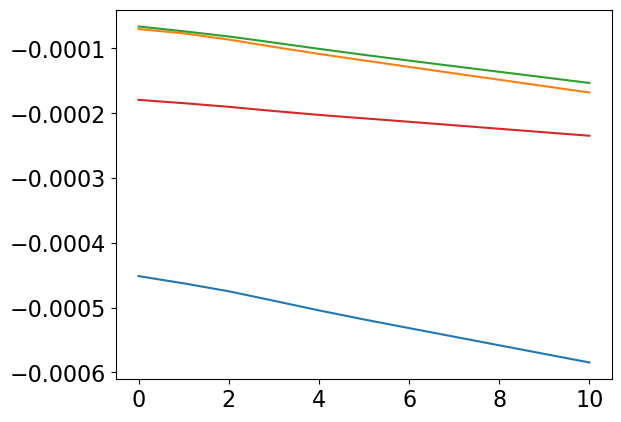

In [85]:
for k, v in q_trans['g_amp'].items():
    plt.plot(v-q_true['g_amp'][k])
    # plt.plot(, 'k')

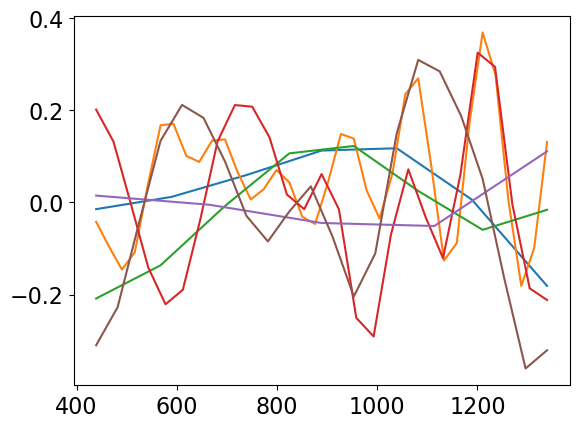

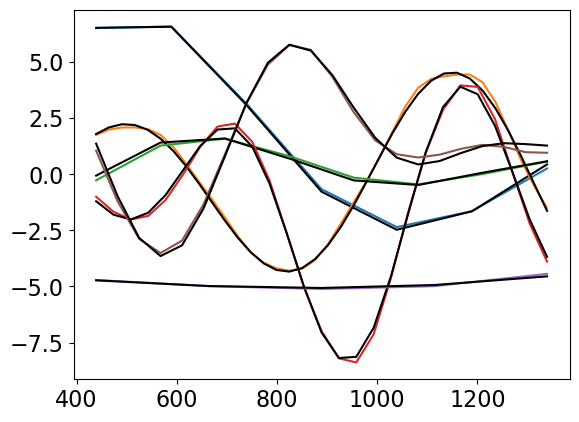

In [96]:
for k, v in q_trans['v_real'].items():
    plt.plot(vis_times[k], v-q_true['v_real'][k])
plt.figure()
for k, v in q_trans['v_real'].items():
    plt.plot(vis_times[k], v)
    plt.plot(vis_times[k], q_true['v_real'][k], 'k')

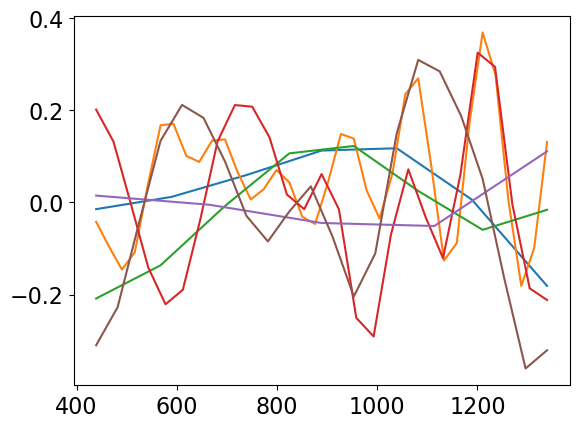

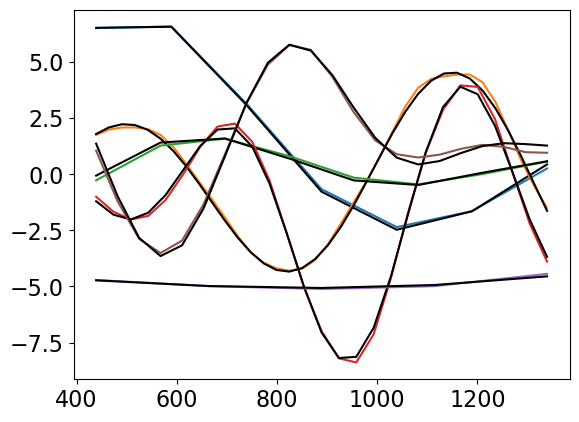

In [98]:
key = 'v_real'
for k, v in q_trans[key].items():
    plt.plot(vis_times[k], v-q_true[key][k])
plt.figure()
for k, v in q_trans[key].items():
    plt.plot(vis_times[k], v)
    plt.plot(vis_times[k], q_true[key][k], 'k')

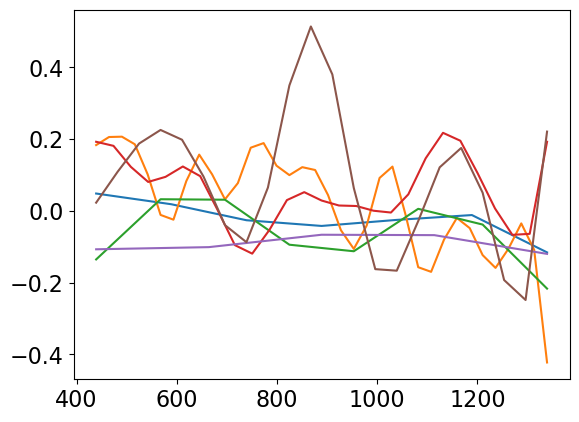

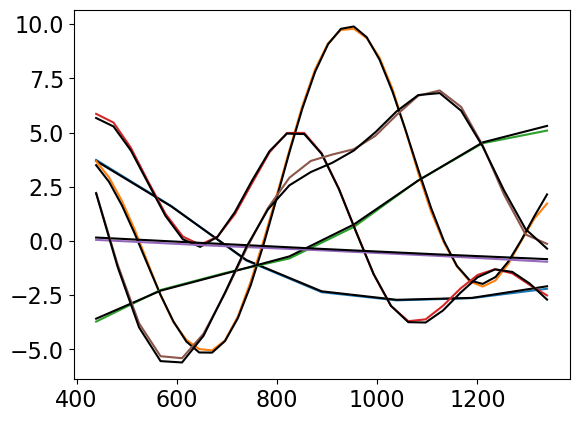

In [97]:
key = 'v_imag'
for k, v in q_trans[key].items():
    plt.plot(vis_times[k], v-q_true[key][k])
plt.figure()
for k, v in q_trans[key].items():
    plt.plot(vis_times[k], v)
    plt.plot(vis_times[k], q_true[key][k], 'k')